# WISDM Activity Classification - 1D-CNN with FFT Features

**Objective:** Train CNN on WISDM raw accelerometer data with user-independent validation

**Key Features:**
- Raw time-domain + FFT frequency-domain features (6 channels)
- SMOTE for class balancing
- User-independent train/test split (no user overlap)
- 1D-CNN architecture for automatic pattern learning

## 1. Setup & Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print("Libraries imported successfully!")

TensorFlow version: 2.20.0
Libraries imported successfully!


## 2. Load Data

In [2]:
def load_raw_data(file_path):
    """Load WISDM raw accelerometer data"""
    data = []
    with open(file_path, 'rt', encoding='utf-8') as file:
        for line in file:
            if not line.strip():
                continue

            # Format: user,activity,timestamp,x-accel,y-accel,z-accel;
            parts = line.strip().replace(';', '').split(',')
            if len(parts) < 6:
                continue

            cleaned_parts = []
            for part in parts[:6]:
                part = part.strip()
                if not part:
                    cleaned_parts.append(np.nan)
                else:
                    cleaned_parts.append(part)

            data.append(cleaned_parts)

    columns = ['user_id', 'activity', 'timestamp', 'x_accel', 'y_accel', 'z_accel']
    df = pd.DataFrame(data, columns=columns)

    # Convert to numeric
    df['user_id'] = pd.to_numeric(df['user_id'], errors='coerce')
    for col in ['x_accel', 'y_accel', 'z_accel']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop rows with missing values
    df.dropna(inplace=True)
    df['user_id'] = df['user_id'].astype(int)

    return df

# Load data
data_path = '../WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'
df = load_raw_data(data_path)

print(f"Total records: {len(df):,}")
print(f"\nUsers: {df['user_id'].nunique()}")
print(f"\nActivity distribution:")
print(df['activity'].value_counts())
print(f"\nSample data:")
df.head()

Total records: 1,098,203

Users: 36

Activity distribution:
activity
Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: count, dtype: int64

Sample data:


,user_id,activity,timestamp,x_accel,y_accel,z_accel
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


## 3. Filter Client C Users

In [3]:
# Load client_C to see which users it contains
client_c = pd.read_csv('../WISDM_ar_v1.1/client_C.csv')
client_c_users = client_c['user'].unique()

print(f"Client C users: {sorted(client_c_users)}")

# Filter raw data to these users
df = df[df['user_id'].isin(client_c_users)].copy()

print(f"\nFiltered records: {len(df):,}")
print(f"\nActivity distribution (Client C users):")
print(df['activity'].value_counts())

Client C users: [np.int64(6), np.int64(7), np.int64(8), np.int64(15), np.int64(18), np.int64(22), np.int64(23), np.int64(24), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]

Filtered records: 392,104

Activity distribution (Client C users):
activity
Jogging       139578
Walking       138514
Upstairs       42894
Downstairs     33609
Sitting        21045
Standing       16464
Name: count, dtype: int64


## 4. Create Time Windows

In [4]:
def create_windows(df, window_size=200, step_size=100):
    """
    Create sliding windows from continuous accelerometer data
    
    Args:
        df: DataFrame with user_id, activity, x_accel, y_accel, z_accel
        window_size: Number of timesteps per window (default: 200 = 10 seconds)
        step_size: Overlap between windows (default: 100 = 50% overlap)
    
    Returns:
        windows: Array of shape (n_windows, window_size, 3)
        labels: Array of activity labels for each window
    """
    windows = []
    labels = []
    
    # Group by user and activity to avoid mixing different activities
    for (user, activity), group in df.groupby(['user_id', 'activity']):
        data = group[['x_accel', 'y_accel', 'z_accel']].values
        
        # Create overlapping windows
        for i in range(0, len(data) - window_size, step_size):
            window = data[i:i + window_size]
            
            # Ensure window is exactly window_size
            if window.shape[0] == window_size:
                windows.append(window)
                labels.append(activity)
    
    return np.array(windows, dtype=np.float32), np.array(labels)

# Create windows
print("Creating time windows...")
WINDOW_SIZE = 200  # 10 seconds at 20Hz
STEP_SIZE = 100    # 50% overlap

X, y = create_windows(df, WINDOW_SIZE, STEP_SIZE)

print(f"\nWindows created: {X.shape[0]:,}")
print(f"Window shape: {X.shape}  # (samples, timesteps, channels)")
print(f"\nClass distribution:")
unique, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  {cls}: {count} ({count/len(y)*100:.1f}%)")

Creating time windows...

Windows created: 3,815
Window shape: (3815, 200, 3)  # (samples, timesteps, channels)

Class distribution:
  Downstairs: 319 (8.4%)
  Jogging: 1376 (36.1%)
  Sitting: 193 (5.1%)
  Standing: 150 (3.9%)
  Upstairs: 413 (10.8%)
  Walking: 1364 (35.8%)


## 6. Add FFT Features

Compute Fast Fourier Transform on each axis to capture frequency patterns.

## 5. Encode Labels & User Split

In [5]:
# Encode activity labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

print(f"Activity classes: {label_encoder.classes_}")
print(f"Number of classes: {num_classes}")

# User-independent split: separate users into train/test
all_users = df['user_id'].unique()
train_users, test_users = train_test_split(all_users, test_size=0.3, random_state=42)

print(f"\nUser split:")
print(f"  Total users: {len(all_users)}")
print(f"  Train users: {len(train_users)} - {sorted(train_users)}")
print(f"  Test users: {len(test_users)} - {sorted(test_users)}")

# Split data by users
df_train_ui = df[df['user_id'].isin(train_users)].copy()
df_test_ui = df[df['user_id'].isin(test_users)].copy()

print(f"\nData split:")
print(f"  Train records: {len(df_train_ui):,}")
print(f"  Test records: {len(df_test_ui):,}")

Activity classes: ['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']
Number of classes: 6

User split:
  Total users: 13
  Train users: 9 - [np.int64(6), np.int64(7), np.int64(8), np.int64(15), np.int64(18), np.int64(24), np.int64(32), np.int64(35), np.int64(36)]
  Test users: 4 - [np.int64(22), np.int64(23), np.int64(33), np.int64(34)]

Data split:
  Train records: 278,721
  Test records: 113,383


In [6]:
def add_fft_features(windows):
    """
    Compute FFT magnitude spectrum for each window and concatenate with time-domain data
    
    Args:
        windows: Array of shape (n_windows, window_size, 3) - time domain data
    
    Returns:
        combined: Array with both time and frequency domain features
                 Shape: (n_windows, window_size, 6) where:
                 - channels 0-2: time domain (x, y, z)
                 - channels 3-5: FFT magnitude (x, y, z)
    """
    n_samples, window_size, n_channels = windows.shape
    
    # Initialize array for FFT features
    fft_features = np.zeros_like(windows)
    
    # Compute FFT for each axis
    for i in range(n_samples):
        for axis in range(n_channels):
            # Compute FFT and take magnitude
            fft_result = np.fft.fft(windows[i, :, axis])
            # Use only the positive frequencies (first half)
            fft_magnitude = np.abs(fft_result[:window_size])
            fft_features[i, :, axis] = fft_magnitude
    
    # Concatenate time-domain and frequency-domain features
    combined = np.concatenate([windows, fft_features], axis=2)
    
    print(f"Original shape: {windows.shape}")
    print(f"FFT features shape: {fft_features.shape}")
    print(f"Combined shape: {combined.shape}")
    
    return combined

# Add FFT features to the data
print("Computing FFT features...")
X_with_fft = add_fft_features(X)
print(f"\nData now has {X_with_fft.shape[2]} channels:")
print("  - Channels 0-2: Time domain (x, y, z accelerations)")
print("  - Channels 3-5: Frequency domain (FFT magnitude of x, y, z)")

Computing FFT features...
Original shape: (3815, 200, 3)
FFT features shape: (3815, 200, 3)
Combined shape: (3815, 200, 6)

Data now has 6 channels:
  - Channels 0-2: Time domain (x, y, z accelerations)
  - Channels 3-5: Frequency domain (FFT magnitude of x, y, z)


## 7. Create Windows with FFT (User-Independent)

In [7]:
# User-independent split with FFT features
print("Creating user-independent train/test split for FFT data...")

# Create windows for train and test users separately
X_train_ui_fft, y_train_ui_fft = create_windows(df_train_ui, WINDOW_SIZE, STEP_SIZE)
X_test_ui_fft, y_test_ui_fft = create_windows(df_test_ui, WINDOW_SIZE, STEP_SIZE)

# Add FFT features
print("\nAdding FFT features to train set...")
X_train_ui_fft = add_fft_features(X_train_ui_fft)

print("\nAdding FFT features to test set...")
X_test_ui_fft = add_fft_features(X_test_ui_fft)

print(f"\n{'='*60}")
print(f"User-Independent Split with FFT:")
print(f"  Train users: {len(train_users)}, Test users: {len(test_users)}")
print(f"  Train windows: {X_train_ui_fft.shape[0]:,}")
print(f"  Test windows: {X_test_ui_fft.shape[0]:,}")
print(f"  Input shape: {X_train_ui_fft.shape[1:]} (timesteps, channels)")
print(f"{'='*60}")

Creating user-independent train/test split for FFT data...

Adding FFT features to train set...
Original shape: (2710, 200, 3)
FFT features shape: (2710, 200, 3)
Combined shape: (2710, 200, 6)

Adding FFT features to test set...
Original shape: (1105, 200, 3)
FFT features shape: (1105, 200, 3)
Combined shape: (1105, 200, 6)

User-Independent Split with FFT:
  Train users: 9, Test users: 4
  Train windows: 2,710
  Test windows: 1,105
  Input shape: (200, 6) (timesteps, channels)


## 8. Apply SMOTE (Class Balancing)

In [8]:
# Encode labels
y_train_ui_fft_encoded = label_encoder.transform(y_train_ui_fft)
y_test_ui_fft_encoded = label_encoder.transform(y_test_ui_fft)

# Reshape for SMOTE (flatten 3D to 2D)
n_samples_train = X_train_ui_fft.shape[0]
n_features = X_train_ui_fft.shape[1] * X_train_ui_fft.shape[2]  # 200 * 6 = 1200

X_train_ui_fft_flat = X_train_ui_fft.reshape(n_samples_train, n_features)

print(f"Before SMOTE - FFT data:")
unique, counts = np.unique(y_train_ui_fft_encoded, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls} ({label_encoder.inverse_transform([cls])[0]}): {count}")

# Apply SMOTE
smote_fft = SMOTE(k_neighbors=5, random_state=42)
X_train_ui_fft_resampled_flat, y_train_ui_fft_resampled = smote_fft.fit_resample(
    X_train_ui_fft_flat, y_train_ui_fft_encoded
)

# Reshape back to 3D
X_train_ui_fft_resampled = X_train_ui_fft_resampled_flat.reshape(-1, WINDOW_SIZE, 6)

print(f"\nAfter SMOTE - FFT data:")
unique, counts = np.unique(y_train_ui_fft_resampled, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls} ({label_encoder.inverse_transform([cls])[0]}): {count}")

print(f"\nFinal training set shape: {X_train_ui_fft_resampled.shape}")

Before SMOTE - FFT data:
  Class 0 (Downstairs): 195
  Class 1 (Jogging): 1038
  Class 2 (Sitting): 148
  Class 3 (Standing): 123
  Class 4 (Upstairs): 254
  Class 5 (Walking): 952

After SMOTE - FFT data:
  Class 0 (Downstairs): 1038
  Class 1 (Jogging): 1038
  Class 2 (Sitting): 1038
  Class 3 (Standing): 1038
  Class 4 (Upstairs): 1038
  Class 5 (Walking): 1038

Final training set shape: (6228, 200, 6)


In [9]:
def create_cnn_model(input_shape, num_classes):
    """
    Create 1D-CNN model for activity recognition
    
    Args:
        input_shape: (timesteps, channels)
        num_classes: Number of activity classes
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # Conv Block 1
        layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        # Conv Block 2
        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        # Conv Block 3
        layers.Conv1D(256, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.4),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Setup callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

callbacks = [early_stop]
print("✓ Model architecture and callbacks defined")

✓ Model architecture and callbacks defined


## 9. Build CNN Model

In [10]:
# Create model for FFT features (6 channels instead of 3)
input_shape_fft = (WINDOW_SIZE, 6)  # 200 timesteps, 6 channels (3 time + 3 freq)

model_fft = create_cnn_model(input_shape_fft, num_classes)
print(f"\nModel created with input shape: {input_shape_fft}")
print(f"Total parameters: {model_fft.count_params():,}")


Model created with input shape: (200, 6)
Total parameters: 907,910


## 10. Train Model

In [11]:
# Train model with FFT features
print("Training CNN with FFT features (user-independent split)...")
print(f"Training on {len(train_users)} users, validating on {len(test_users)} users")

history_fft = model_fft.fit(
    X_train_ui_fft_resampled,
    y_train_ui_fft_resampled,
    validation_data=(X_test_ui_fft, y_test_ui_fft_encoded),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training complete!")

Training CNN with FFT features (user-independent split)...
Training on 9 users, validating on 4 users
Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5841 - loss: 1.6384 - val_accuracy: 0.8271 - val_loss: 0.5341
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8446 - loss: 0.3545 - val_accuracy: 0.8760 - val_loss: 0.3220
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8971 - loss: 0.2532 - val_accuracy: 0.8842 - val_loss: 0.3940
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9324 - loss: 0.1785 - val_accuracy: 0.8733 - val_loss: 0.5163
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9469 - loss: 0.1437 - val_accuracy: 0.8643 - val_loss: 0.5990
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9597 - loss: 0.1185 - val_accuracy: 0.8751 - val_loss: 0.6888
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9645 - loss: 0.1025 - val_accuracy: 0.8217 - val_loss: 1.0469
Epoch 8/

## 11. Evaluate Model

In [12]:
# Evaluate FFT model
y_pred_fft = model_fft.predict(X_test_ui_fft)
y_pred_fft = np.argmax(y_pred_fft, axis=1)

# Metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report

accuracy_fft = accuracy_score(y_test_ui_fft_encoded, y_pred_fft)
balanced_acc_fft = balanced_accuracy_score(y_test_ui_fft_encoded, y_pred_fft)
f1_macro_fft = f1_score(y_test_ui_fft_encoded, y_pred_fft, average='macro')
f1_weighted_fft = f1_score(y_test_ui_fft_encoded, y_pred_fft, average='weighted')

print("="*60)
print("FFT MODEL - USER-INDEPENDENT EVALUATION")
print("="*60)
print(f"Accuracy:           {accuracy_fft:.4f}")
print(f"Balanced Accuracy:  {balanced_acc_fft:.4f}")
print(f"F1-Score (Macro):   {f1_macro_fft:.4f}")
print(f"F1-Score (Weighted): {f1_weighted_fft:.4f}")
print("="*60)

print("\nClassification Report:")
print(classification_report(
    y_test_ui_fft_encoded, 
    y_pred_fft, 
    target_names=label_encoder.classes_
))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
FFT MODEL - USER-INDEPENDENT EVALUATION
Accuracy:           0.8842
Balanced Accuracy:  0.8766
F1-Score (Macro):   0.8716
F1-Score (Weighted): 0.8852

Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.63      0.53      0.58       124
     Jogging       0.97      0.90      0.93       338
     Sitting       1.00      1.00      1.00        45
    Standing       1.00      1.00      1.00        27
    Upstairs       0.66      0.86      0.75       159
     Walking       0.98      0.97      0.97       412

    accuracy                           0.88      1105
   macro avg       0.87      0.88      0.87      1105
weighted avg       0.89      0.88      0.89      1105



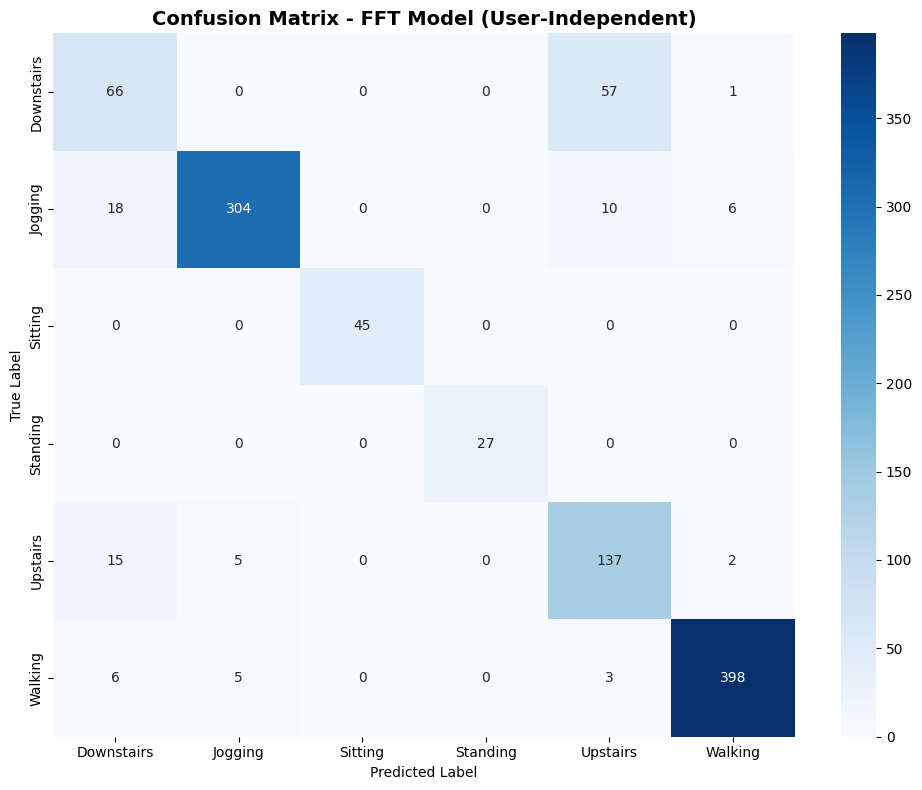

In [13]:
# Confusion Matrix for FFT model
from sklearn.metrics import confusion_matrix

cm_fft = confusion_matrix(y_test_ui_fft_encoded, y_pred_fft)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_fft, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - FFT Model (User-Independent)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

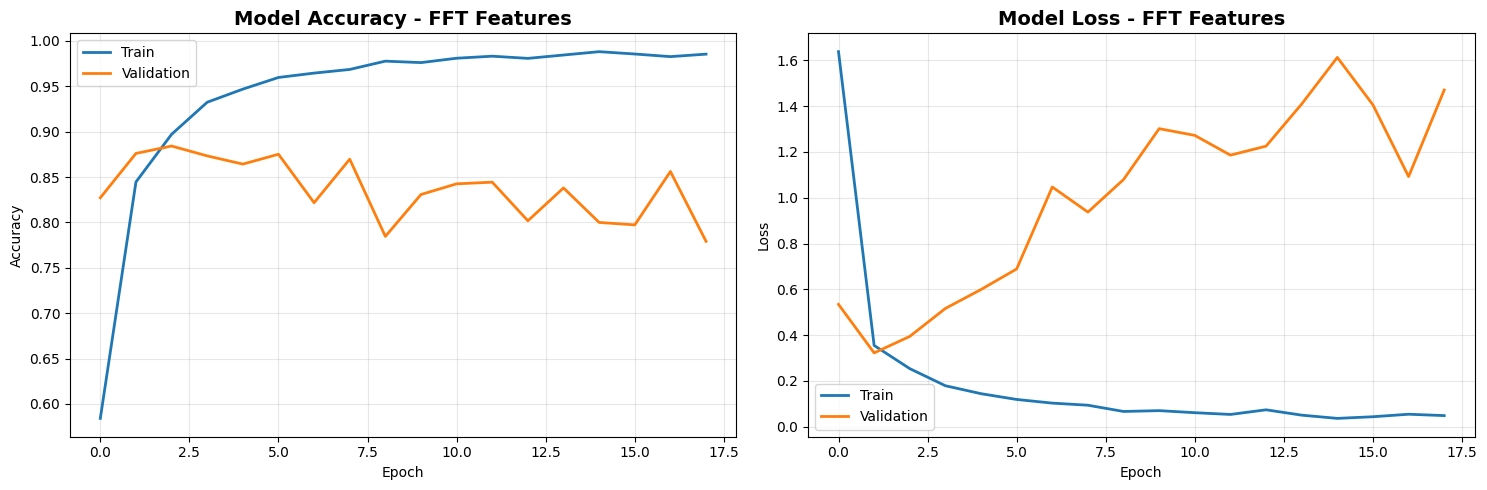

In [14]:
# Training curves for FFT model
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_fft.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_fft.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy - FFT Features', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history_fft.history['loss'], label='Train', linewidth=2)
axes[1].plot(history_fft.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Model Loss - FFT Features', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Results Summary

**Note:** The comparison cells below reference a baseline time-domain model. If you haven't trained one yet, you can comment out these cells or train a baseline model first by creating windows without FFT features.

In [ ]:
# Compare Time Domain vs FFT Features
# comparison_models = pd.DataFrame({
#     'Model': ['Time Domain Only', 'Time + FFT Features'],
#     'Input Channels': [3, 6],
#     'Accuracy': [accuracy_ui, accuracy_fft],
#     'Balanced Accuracy': [balanced_acc_ui, balanced_acc_fft],
#     'F1-Score (Macro)': [f1_macro_ui, f1_macro_fft],
#     'F1-Score (Weighted)': [f1_weighted_ui, f1_weighted_fft]
# })

# print("="*80)
# print("MODEL COMPARISON - USER-INDEPENDENT EVALUATION")
# print("="*80)
# print(comparison_models.to_string(index=False))
# print("="*80)

# # Calculate improvement
# acc_improvement = (accuracy_fft - accuracy_ui) / accuracy_ui * 100
# f1_improvement = (f1_macro_fft - f1_macro_ui) / f1_macro_ui * 100

# print(f"\nImprovements with FFT features:")
# print(f"  Accuracy: {acc_improvement:+.2f}%")
# print(f"  F1-Score (Macro): {f1_improvement:+.2f}%")

NameError: name 'accuracy_ui' is not defined

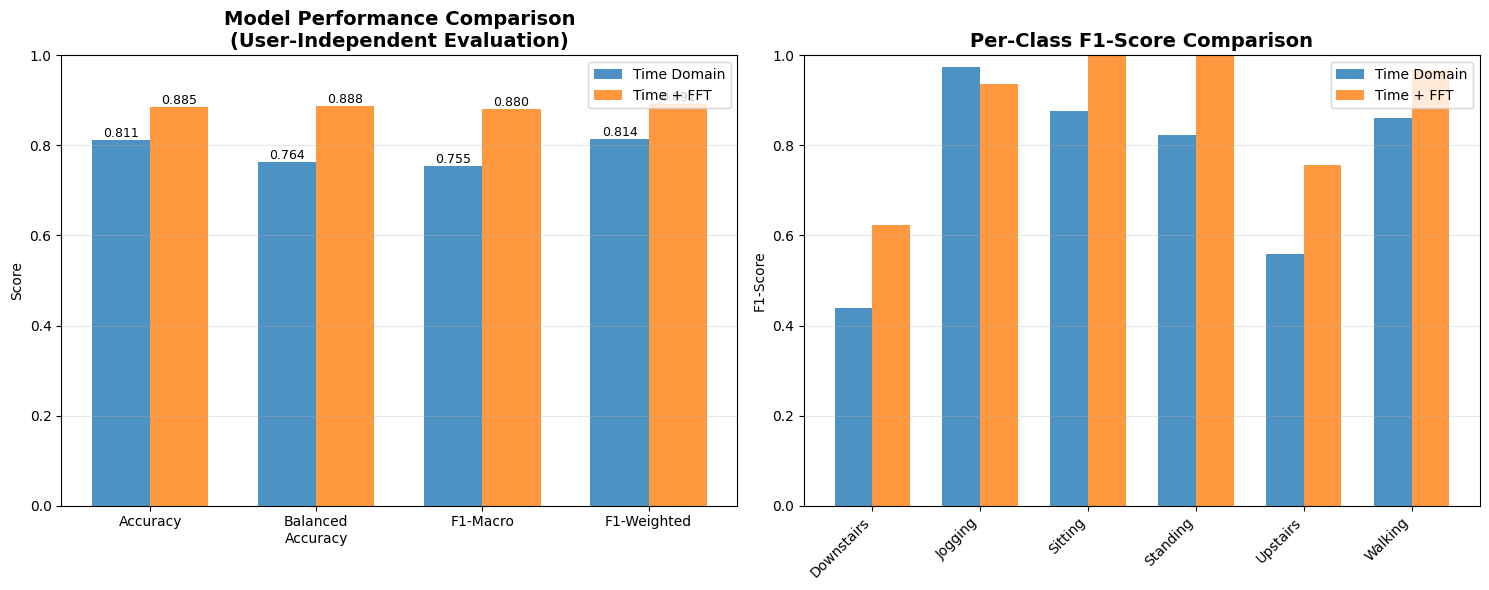

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Metrics comparison
metrics = ['Accuracy', 'Balanced\nAccuracy', 'F1-Macro', 'F1-Weighted']
time_domain_scores = [accuracy_ui, balanced_acc_ui, f1_macro_ui, f1_weighted_ui]
fft_scores = [accuracy_fft, balanced_acc_fft, f1_macro_fft, f1_weighted_fft]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, time_domain_scores, width, label='Time Domain', alpha=0.8)
bars2 = axes[0].bar(x + width/2, fft_scores, width, label='Time + FFT', alpha=0.8)

axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison\n(User-Independent Evaluation)', 
                   fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Per-class F1-score comparison
f1_time = f1_score(y_test_ui_encoded, y_pred_ui, average=None)
f1_fft_per_class = f1_score(y_test_ui_fft_encoded, y_pred_fft, average=None)

x_classes = np.arange(len(label_encoder.classes_))
bars1 = axes[1].bar(x_classes - width/2, f1_time, width, label='Time Domain', alpha=0.8)
bars2 = axes[1].bar(x_classes + width/2, f1_fft_per_class, width, label='Time + FFT', alpha=0.8)

axes[1].set_ylabel('F1-Score')
axes[1].set_title('Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_classes)
axes[1].set_xticklabels(label_encoder.classes_, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

## 13. Save Model

In [16]:
# Save the FFT model
model_fft_save_path = 'wisdm_cnn_fft_model.keras'
model_fft.save(model_fft_save_path)
print(f"✓ FFT Model saved successfully to: {os.path.abspath(model_fft_save_path)}")
print(f"  Model size: {os.path.getsize(model_fft_save_path) / (1024*1024):.2f} MB")

✓ FFT Model saved successfully to: d:\THICKTeme_si_Documente\Master\An2\AITDM\WISDM-ActitrackerDataset-WirelessSensorDataMining\Andrei\wisdm_cnn_fft_model.keras
  Model size: 10.45 MB
